**<h3>Python Script Imports</h3>**

In [21]:
import os
import sys
import importlib    
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

#Paths
housing_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/datasets/housing.csv"
python_scripts_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/python-scripts"

#Path initialization so that Python can see where our script lies.
script_dir = os.path.abspath(python_scripts_path) 
sys.path.append(script_dir)

#Imports
from sklearn.model_selection import StratifiedShuffleSplit

from test_set_check import test_set_check

from split_train_test_by_id import split_train_test_by_id
from load_housing_data import load_housing_data

housing = load_housing_data(housing_path)

**<h3>Prepare clean dataset</h3>**
**<h5>Step 1: Create a stratified dataset</h5>**

**Idea:** Split the entire housing dataset into 5 categories of `median_income` This prevents sampling bias (favoring 1 type of `median_income` over the rest.

In [22]:
#limits number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
#merge "larger than 5" categories into category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=False) 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


**<h5>Step 2: Separate predictors and labels </h5>**

**Definition**

- **Predictors**: Data that the machine learning model learns from to predict future ones.
- **Labels**: The answer letting the machine know if it gives a correct/incorrect prediction.

**Example: `drop()` function**

In [23]:
#1. Creates a new dataset without the answer (median_house_value) 
# so that the ML model can learn from.
housing = strat_train_set.drop("median_house_value", axis=1) 

#2. Creates a table of labels (a.k.a answers), letting the model know
# if it's doing well or not.
housing_labels = strat_train_set["median_house_value"].copy()

print(housing)
print(housing_labels)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
15698    -122.46     37.79                52.0        899.0            96.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
...          ...       ...                 ...          ...             ...   
6563     -118.13     34.20                46.0       1271.0           236.0   
12053    -117.56     33.88                40.0       1196.0           294.0   
13908    -116.40     34.09                 9.0       4855.0           872.0   
11159    -118.01     33.82                31.0       1960.0           380.0   
15775    -122.45     37.77                52.0       3095.0           682.0   

       population  households  median_income ocean_

**<h5>Step 3: Cleans the data</h5>** 

**Idea:** "fix" missing cells in a row (district), like this one (missing total_bedrooms value):
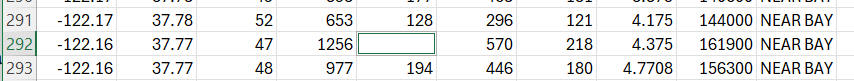

**How to fix:**
- Remove corresponding districts (delete the entire row 292) 

`housing.dropna(subset=["total_bedrooms"])` 

- Remove the entire column (delete the total_bedrooms column) 

`housing.drop("total_bedrooms", axis=1) # option 2` 

- Set that cell to some value (zero/mean/median....) 

`median = housing["total_bedrooms"].median() # option 3`
`housing["total_bedrooms"].fillna(median, inplace=True) `

Note: If option 3 is chosen, **median** value of total_bedrooms must be calculated.

  - **What is Median?** The number in the middle of the "total_bedrooms" list. Here's an example:
    
    + Case 1: `total_bedrooms = [2, 3, 4, 5, 6]` => Median = `4`
    + Case 2: `total_bedrooms = [2, 3, 4, 5, 6, 7]` => Median = `(4+5)/2 = 4.5`



**<h3>Data cleanup with `Imputer()` function</h3>**
**Example**
- Create a SimpleImputer instance
- For each column (e.g. total_bedrooms), do the following:
  + Calculate the median value
  + Fill that median value to the empty cells.

In [24]:
imputer = SimpleImputer(strategy="median")

**Caveats**
- The Imputer only works on **numerical values**. This means **`ocean_proximity`** should be removed when the dataset is copied.
- The `fit()` function **learns the dataset** to find the median value.
  + We will **fill in the empty cells** of the dataset with this **median value** later.
  + According to the book: The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.

In [25]:
# 1. Creates a copy of the housing data, WITHOUT the string column (ocean_proximity)
housing_num = housing.drop("ocean_proximity", axis=1) 

# 2. Use the fit() function to learn from the housing_num dataset, then creates 
# the value to fill in the empty cells.
imputer.fit(housing_num)

#3. Fill the empty cells with the "transform" function. 
# We have X - a dataset with all empty cells filled with the median.
X = imputer.transform(housing_num)

**<h3>Scikit-learn Design Definitions</h3>**
- **Estimators (learners):**
  + A thing/Things that **predict/estimate some parameters** based on the dataset. Simply put, it **learns the current data**, to help predict the future data.
  + Common examples: **`fit()`**  
- **Transformers (do-ers):**
  + A thing/function/object that **transforms/modifies** a dataset, using the learned information. Learned information can be obtained from the **`fit()`** function, for example.
- **Predictors:**
  + Predicts the future data based on a given dataset.
- **Inspection:**
  + A way for us to know **what values are being held by**, for example, the **predictors**.
  + It's the same as attributes in an Object (Object-Oriented Programming).
  + Examples:
    +  **`imputer.strategy`**: Gets the used strategy from the **`imputer`** object.
    +  **`imputer.statistics`**: Gets the statistics from the **`imputer`** object.

**<h3>Handling Text/Categorical values </h3>**


**Method 1: Convert Text to Number using  Panda's **`factorize()`** method**

**Steps**
- Extract the **`ocean_proximity`**  column from the original dataset, and store the result in **`housing_cat`** variable (which is now a dataset with 1 column of **`ocean_proximity`**)
- Use **`factorize()`** to convert them to numbers.

In [26]:
housing_cat = housing["ocean_proximity"]
housing_cat_encoded, housing_categories = housing_cat.factorize()
print("Housing categories in integer:" + str(housing_cat_encoded[:10]))
print("Housing categories:" +str(housing_categories))

Housing categories in integer:[0 1 2 3 0 3 2 3 0 0]
Housing categories:Index(['<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'INLAND', 'ISLAND'], dtype='object')
